In [2]:
import os

if not os.path.exists("VoxCeleb_gender"):
    !pip install gdown pydub librosa
    !gdown https://drive.google.com/uc?id=1V3lNnSDv71AJYIj71V4_xD0ir0DrXxEV
    !tar -xf VoxCeleb_gender.zip #!tar -xf VoxCeleb_gender.zip
    !del VoxCeleb_gender.zip     #!del

else:
    print("Dataset already downloaded.")

Dataset already downloaded.


In [3]:
import librosa
import scipy.signal as ss
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

def extract_mfcc(file_path, n_mfcc=12, win_length=320, hop_length=160):
    wave, sr = librosa.load(file_path, mono=True, sr=None)
    if sr != 16000:
        wave = librosa.resample(wave, sr, 16000)
    mfcc = librosa.feature.mfcc(y=wave, sr=16000, n_mfcc=n_mfcc, window=ss.windows.hamming, win_length=win_length, hop_length=hop_length)
    return mfcc

# Build data in memory

In [63]:
mfcc_coeff_amount = 12
window_length = int(16000*0.02)

In [33]:
arr = []
if not os.path.exists(f"mfcc_{mfcc_coeff_amount}_{window_length}.pkl"):

    aux = []

    for (dirpath, dirnames, filenames) in os.walk("VoxCeleb_gender"):
        for filename in filenames:
            if filename.endswith(".wav"):
                filepath = dirpath + "/" + filename
                aux.append({"file": filepath, "gender": dirpath.split("\\")[-1]})

    df = pd.DataFrame(aux)

    df["mfcc"] = pd.Series(name="mfcc", dtype=object)

    for i in range(len(df)):
        mfcc_coeffs = extract_mfcc(df.loc[i, "file"], n_mfcc=mfcc_coeff_amount, win_length=window_length)
        for i, coeffs in enumerate(mfcc_coeffs):
            if np.linalg.norm(coeffs) < 1:
                mfcc_coeffs.pop(i)
        arr.append(mfcc_coeffs)
    df["mfcc"] = arr
    df.to_pickle(f"mfcc_{mfcc_coeff_amount}_{window_length}.pkl")
else:
    print("File Found")
    df = pd.read_pickle(f"mfcc_{mfcc_coeff_amount}_{window_length}.pkl")


num_males = len(df.loc[df.gender == "males"] )           
num_females = len(df.loc[df.gender == "females"] )              

File Found


In [64]:
print("Number of males: ", num_males)
print("Number of females: ", num_females)

Number of males:  3682
Number of females:  2311


In [65]:
display(df) #Cada fila tiene los datos de un audio, cada columna mfcc contiene n_mfcc x timesteps 

,file,gender,mfcc
0,VoxCeleb_gender\females/0.wav,females,"[[-297.64233, -311.51636, -333.22858, -353.112..."
1,VoxCeleb_gender\females/1.wav,females,"[[-237.64122, -249.89484, -260.6425, -261.0365..."
2,VoxCeleb_gender\females/10.wav,females,"[[-442.06046, -442.974, -473.21695, -495.31973..."
3,VoxCeleb_gender\females/100.wav,females,"[[-217.43253, -215.3289, -202.59782, -189.7104..."
4,VoxCeleb_gender\females/1000.wav,females,"[[-310.47504, -292.76688, -310.6037, -303.5888..."
...,...,...,...
5988,VoxCeleb_gender\males/995.wav,males,"[[-486.3795, -482.37906, -486.09213, -493.3973..."
5989,VoxCeleb_gender\males/996.wav,males,"[[-296.01495, -315.97952, -288.9254, -280.0321..."
5990,VoxCeleb_gender\males/997.wav,males,"[[-539.7124, -535.8697, -522.5412, -559.24457,..."
5991,VoxCeleb_gender\males/998.wav,males,"[[-674.96234, -657.79913, -662.2179, -658.7952..."


In [135]:
from sklearn.model_selection import train_test_split

#Equalize number of gender in dataset
gender_counts = df['gender'].value_counts()
difference = abs(gender_counts['males'] - gender_counts['females'])
if gender_counts['males'] > gender_counts['females']:
    df_balanced = df.drop(df[df['gender'] == 'males'].sample(n=difference, random_state=42).index)
else:
    df_balanced = df.drop(df[df['gender'] == 'females'].sample(n=difference, random_state=42).index)

#Split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(df_balanced.drop(['gender'], axis=1), df_balanced['gender'], test_size=0.2)
X_file, X_test_file = X_train["file"], X_test["file"]
X_train.drop(["file"], inplace=True, axis=1)
X_test.drop(["file"], inplace=True, axis=1)


# EDA

In [36]:
# Get the mean mfcc coefficients for each class
mean_mfcc_males = 0
mean_mfcc_females = 0

for person in df.iterrows():
    for i in range(len(person[1]["mfcc"])//mfcc_coeff_amount):
        if person[1]["gender"] == "males":
            mean_mfcc_males = np.mean(np.array(person[1]["mfcc"]), axis=1)/num_males
        else:
            mean_mfcc_females = np.mean(person[1]["mfcc"], axis=1)/num_females

display(mean_mfcc_males)
display(mean_mfcc_females)

array([-0.11897212,  0.03945716, -0.00423559,  0.01269617, -0.00352437,
        0.00430585, -0.00506555,  0.00012289, -0.00246526, -0.00099982,
       -0.00170587,  0.00013982], dtype=float32)

array([-1.6783497e-01,  3.9344601e-02, -6.0754974e-04,  1.6567115e-02,
       -5.1081921e-03, -1.4276202e-04, -8.7756226e-03, -2.9270588e-03,
       -1.5782913e-03, -7.5654369e-03, -2.2530130e-03, -7.1545928e-03],
      dtype=float32)

In [37]:
score_males = []
score_females = []

for i in range(1000):
    score_males.append(np.sum(df.mfcc[df.gender=="males"][i], axis=1) @ mean_mfcc_males)
    score_females.append(np.sum(df.mfcc[df.gender=="females"][i + num_males], axis=1) @ mean_mfcc_males)


KeyError: 0

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

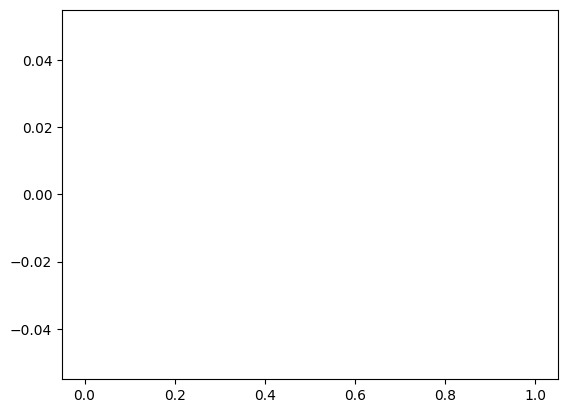

In [134]:
plt.hist(score_males, bins=20)
plt.hist(score_females, bins=20, alpha=0.5)

# GMM Model

In [215]:
amount = 50
X_male = np.concatenate(X_train.mfcc[y_train=="males"].to_numpy()[:amount], axis=1).T
X_female = np.concatenate(X_train.mfcc[y_train=="females"].to_numpy()[:amount], axis=1).T
X_test_male = np.concatenate(X_test.mfcc[y_test=="males"].to_numpy()[:amount], axis=1).T
X_test_female = np.concatenate(X_test.mfcc[y_test=="females"].to_numpy()[:amount], axis=1).T

In [224]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV

gmm_male = GaussianMixture(n_components=mfcc_coeff_amount, covariance_type='full', max_iter=1000)
gmm_female = GaussianMixture(n_components=mfcc_coeff_amount, covariance_type='full', max_iter=1000)

gmm_male.fit(X_male)
gmm_female.fit(X_female)

GaussianMixture(max_iter=1000, n_components=12)

In [225]:
import pickle

with open('gmm_male.pkl','wb') as f:
    pickle.dump(gmm_male,f)

with open('gmm_female.pkl','wb') as f:
    pickle.dump(gmm_female,f)

(array([  1.,   1.,   3.,   2.,   3.,  14.,  10.,  16.,  26.,  31.,  53.,
         91., 109., 152., 141., 133.,  93.,  88.,  53.,  37.,  29.,   4.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          5.]),
 array([-64.19670694, -63.38226528, -62.56782363, -61.75338198,
        -60.93894032, -60.12449867, -59.31005701, -58.49561536,
        -57.68117371, -56.86673205, -56.0522904 , -55.23784875,
        -54.42340709, -53.60896544, -52.79452378, -51.98008213,
        -51.16564048, -50.35119882, -49.53675717, -48.72231552

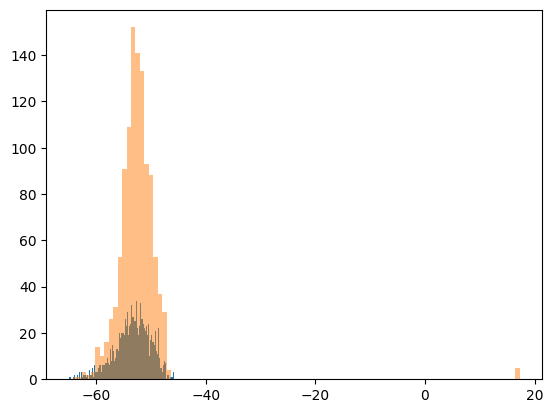

In [229]:
# Lo importante de estos scores es cuanto suman
person = 1
plt.hist(gmm_female.score_samples(X_test.mfcc.iloc[person].T), bins=100)
plt.hist(gmm_male.score_samples(X_test.mfcc.iloc[person].T), bins=100, alpha=0.5)

In [230]:
scores_fvsm = pd.Series(index=y_test.index)
scores_mvsm = pd.Series(index=y_test.index)

for index, row in X_test.iterrows():
    mfcc = row['mfcc']
    scores_fvsm[index] = gmm_female.score_samples(mfcc.T).sum()
    scores_mvsm[index] = gmm_male.score_samples(mfcc.T).sum()

C:\Users\Gonzalo\AppData\Local\Temp\ipykernel_10160\1261772109.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  scores_fvsm = pd.Series(index=y_test.index)
C:\Users\Gonzalo\AppData\Local\Temp\ipykernel_10160\1261772109.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  scores_mvsm = pd.Series(index=y_test.index)


In [231]:
predictions = []
for index in y_test.index:
    if scores_mvsm[index] > scores_fvsm[index]:
        predictions.append('males')
    else:
        predictions.append('females')

# Convert predictions to a pandas Series
predictions = pd.Series(predictions, index=y_test.index)

# Calculate the accuracy
accuracy = (predictions == y_test).mean()

# Print the accuracy
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 84.43%


# Busqueda de hiperparametros

In [52]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV


def gmm_bic_score(estimator, X):
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)


param_grid = {
    "n_components": range(8, 13),
    "covariance_type": ["full", "tied", "diag", "spherical"],
}

grid_search = GridSearchCV(GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score)
grid_search.fit(X_male)

KeyboardInterrupt: 

In [30]:
import pandas as pd

df = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
df["mean_test_score"] = -df["mean_test_score"]
df = df.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)
df.sort_values(by="BIC score").head()

,Number of components,Type of covariance,BIC score
10,8,diag,-33461.914926
11,9,diag,-33442.472437
12,10,diag,-33374.092174
13,11,diag,-33264.468986
5,8,tied,-33140.519868


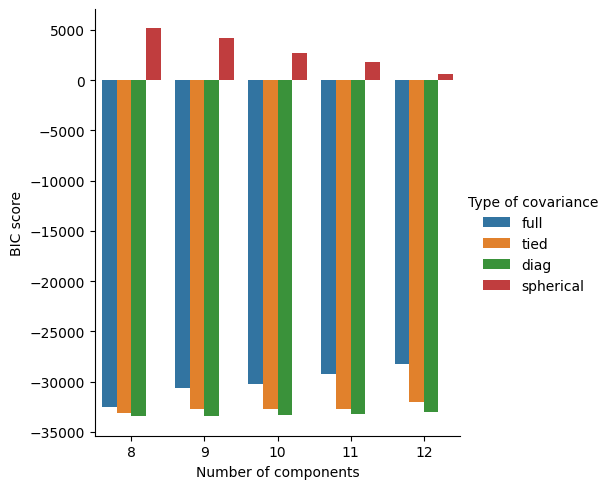

In [31]:
import seaborn as sns

sns.catplot(
    data=df,
    kind="bar",
    x="Number of components",
    y="BIC score",
    hue="Type of covariance",
)
plt.show()